# Learn to Throw
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/Learn_to_Throw_Tutorial.ipynb)

In this notebook, we will train a fully-connected neural network to solve an inverse ballistics problem.
We will compare supervised training to differentiable physics training, both numerically and visually.

[**Φ-Flow**](https://github.com/tum-pbs/PhiFlow)
&nbsp;&nbsp;&nbsp; [**Documentation**](https://tum-pbs.github.io/PhiFlow/)
&nbsp;&nbsp;&nbsp; [**API**](https://tum-pbs.github.io/PhiFlow/phi)
&nbsp;&nbsp;&nbsp; [**Demos**](https://github.com/tum-pbs/PhiFlow/tree/develop/demos)

In [1]:
# !pip install phiflow

In [1]:
# from phi.tf.flow import *
from phi.torch.flow import *
# from phi.jax.stax.flow import *

To define the physics problem, we write a function to simulate the forward physics. This function takes the initial position, height, speed and angle of a thrown object and computes where the object will land, assuming the object follows a parabolic trajectory. Neglecting friction, can compute this by solving a quadratic equation.

In [2]:
def simulate_hit(pos, height, vel, angle, gravity=1.):
    vel_x, vel_y = math.cos(angle) * vel, math.sin(angle) * vel
    height = math.maximum(height, .5)
    hit_time = (vel_y + math.sqrt(vel_y**2 + 2 * gravity * height)) / gravity
    return pos + vel_x * hit_time, hit_time, height, vel_x, vel_y

simulate_hit(10, 1, 1, 0)[0]

11.414213

Let's plot the trajectory! We define *y(x)* and sample it on a grid. We have to drop invalid values, such as negative flight times and below-ground points.

<Figure size 864x360 with 1 Axes>

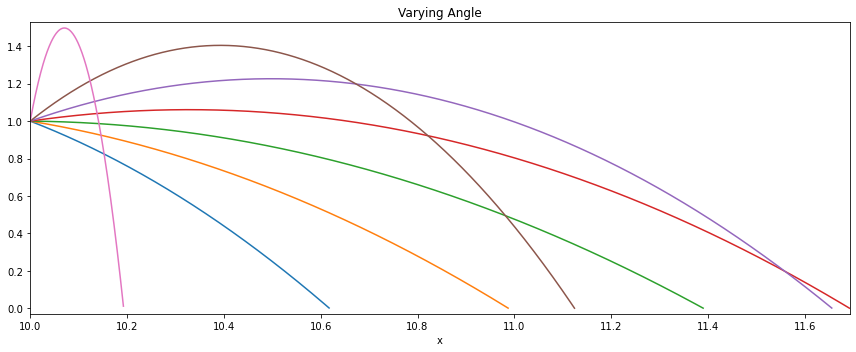

In [3]:
def sample_trajectory(pos, height, vel, angle, gravity=1.):
    hit, hit_time, height, vel_x, vel_y = simulate_hit(pos, height, vel, angle, gravity)
    def y(x):
        t = (x.vector[0] - pos) / vel_x
        y_ = height + vel_y * t - gravity / 2 * t ** 2
        return math.where((y_ > 0) & (t > 0), y_, NAN)
    return CenteredGrid(y, x=2000, bounds=Box(x=(min(pos.min, hit.min), max(pos.max, hit.max))))

vis.plot(sample_trajectory(tensor(10), 1, 1, math.linspace(-PI/4, 1.5, channel(linspace=7))), title="Varying Angle")

Before we train neural networks on this problem, let's perform a classical optimization using gradient descent in the initial velocity `vel`. We need to define a loss function to optimize. Here we desire the object to hit at `x=0`.

In [4]:
vel = tensor(1)

def loss_function(vel):
  return math.l2_loss(simulate_hit(10, 1, vel, 0)[0] - 0)

loss_function(0)

50.0

Φ<sub>Flow</sub> uses the selected library (PyTorch/TensorFlow/Jax) to derive analytic derivatives.
By default, the gradient function also returns the function value.

In [5]:
gradient = math.functional_gradient(loss_function, get_output=True)
gradient(vel)

(65.14213, [16.142136])

vel=-2.2284272 - loss=65.14213
vel=-4.1654835 - loss=23.451168
vel=-5.3277173 - loss=8.442421
vel=-6.0250573 - loss=3.0392709
vel=-6.4434614 - loss=1.0941381
vel=-6.694504 - loss=0.39388976
vel=-6.8451295 - loss=0.14180061
vel=-6.935505 - loss=0.051048037
vel=-6.9897304 - loss=0.018377367
vel=-7.0222654 - loss=0.0066157645


<Figure size 864x360 with 1 Axes>

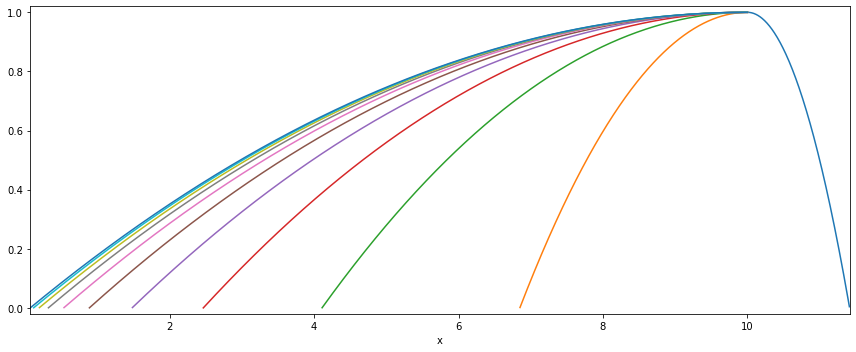

In [6]:
trj = [vel]
for i in range(10):
  loss, (grad,) = gradient(vel)
  vel = vel - .2 * grad
  trj.append(vel)
  print(f"vel={vel} - loss={loss}")
trj = math.stack(trj, channel('opt'))
vis.plot(sample_trajectory(tensor(10), 1, trj, 0))

Now we can just subtract the gradient times a learning rate $\eta = 0.2$ until we converge.

Next, we generate a training set and test by sampling random values.

In [30]:
def generate_data(shape):
  pos = math.random_normal(shape)
  height = math.random_uniform(shape) + .5
  vel = math.random_uniform(shape)
  angle = math.random_uniform(shape) * PI/2
  return math.stack(dict(pos=pos, height=height, vel=vel, angle=angle), channel('vector'))

x_train = generate_data(batch(examples=1000))
x_test = generate_data(batch(examples=1000))
y_train = simulate_hit(*x_train.vector)[0]
y_test = simulate_hit(*x_test.vector)[0]

Now, let's create a fully-connected neural network with three hidden layers. We can reset the `seed` to make the weight initialization predictable.

In [32]:
math.seed(0)
net_sup = dense_net(1, 4, [32, 64, 32])
net_sup

DenseNet(
  (linear0): Linear(in_features=1, out_features=32, bias=True)
  (linear1): Linear(in_features=32, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=4, bias=True)
)

In [60]:
# net_sup.trainable_weights[0]  # TensorFlow
net_sup.state_dict()['linear0.weight'].flatten()  # PyTorch
# net_sup.parameters[0][0]  # Stax

tensor([-0.0075,  0.5884, -0.7979, -0.7646, -0.4088,  0.3018,  0.0102,  0.8287,
        -0.1134,  0.3327, -0.3164, -0.1966, -1.0038, -0.7402, -0.3952,  0.0130,
         0.4065,  0.6272, -0.6946, -0.4294,  0.3627,  0.7943, -0.1923,  0.7780,
        -0.0978,  0.1058,  0.9469, -0.9768, -0.5935, -0.1818, -0.4428,  0.8677],
       device='cuda:0')

For the differentiable physics network we do the same thing again.

In [61]:
math.seed(0)
net_dp = dense_net(1, 4, [32, 64, 32])
# net_dp.trainable_weights[0]  # TensorFlow
net_dp.state_dict()['linear0.weight'].flatten()  # PyTorch
# net_dp.parameters[0][0]  # Stax

tensor([-0.0075,  0.5364, -0.8230, -0.7359, -0.3852,  0.2682, -0.0198,  0.7929,
        -0.0887,  0.2646, -0.3022, -0.1966, -0.9553, -0.6623, -0.4122,  0.0370,
         0.3953,  0.6000, -0.6779, -0.4355,  0.3632,  0.8304, -0.2058,  0.7483,
        -0.1612,  0.1058,  0.9055, -0.9277, -0.6295, -0.2532, -0.3898,  0.8640],
       device='cuda:0')

Indeed, the We see that the networks were initialized identically! Alternatively, we could have saved and loaded the state.

## Supervised Training
Now we can train the network. We feed the desired hit position into the network and predict a possible initial state.
For supervised training, we compare the network prediction to the ground truth from our training set.

In [62]:
opt_sup = adam(net_sup)

def supervised_loss(x, y, net=net_sup):
  prediction = math.native_call(net, y)
  return math.l2_loss(prediction - x)

print(f"Supervised loss (training set): {supervised_loss(x_train, y_train)}")
print(f"Supervised loss (test set): {supervised_loss(x_test, y_test)}")

Supervised loss (training set): (examplesᵇ=1000) float32  0.270 ± 0.179 (3e-03...1e+00)
Supervised loss (test set): (examplesᵇ=1000) float32  0.285 ± 0.187 (1e-02...1e+00)


In [64]:
for i in range(100):
  update_weights(net_sup, opt_sup, supervised_loss, x_train, y_train)

print(f"Supervised loss (training set): {supervised_loss(x_train, y_train)}")
print(f"Supervised loss (test set): {supervised_loss(x_test, y_test)}")

Supervised loss (training set): (examplesᵇ=1000) float32  0.266 ± 0.176 (3e-03...1e+00)
Supervised loss (test set): (examplesᵇ=1000) float32  0.282 ± 0.184 (1e-02...1e+00)


What? That's almost no progress! Feel free to run more iterations but there is a deeper problem at work here. Before we get into that, let's train a the network again but with a differentiable physics loss function.

## Training with Differentiable Physics
For the differentiable physics loss, we simulate the trajectory given the initial conditions predicted by the network. Then we can measure how close to the desired location the network got.

In [65]:
def physics_loss(y, net=net_dp):
  prediction = math.native_call(net, y)
  y_sim = simulate_hit(*prediction.vector)[0]
  return math.l2_loss(y_sim - y)

opt_dp = adam(net_dp)

for i in range(100):
  update_weights(net_dp, opt_dp, physics_loss, y_train)

print(f"Supervised loss (training set): {supervised_loss(x_train, y_train, net=net_dp)}")
print(f"Supervised loss (test set): {supervised_loss(x_test, y_test, net=net_dp)}")

Supervised loss (training set): (examplesᵇ=1000) float32  1.709 ± 0.823 (3e-01...6e+00)
Supervised loss (test set): (examplesᵇ=1000) float32  1.753 ± 0.855 (4e-01...6e+00)


This looks even worse! The differentiable physics network seems to stray even further from the ground truth.
Well, we're not trying to match the ground truth, though. Let's instead measure how close to the desired location the network threw the object.

In [67]:
print(f"Supervised network (test set): {physics_loss(y_test, net=net_sup)}")
print(f"Diff.Phys. network (test set): {physics_loss(y_test, net=net_dp)}")

Supervised network (test set): (examplesᵇ=1000) float32  0.003 ± 0.001 (5e-04...2e-02)
Diff.Phys. network (test set): (examplesᵇ=1000) float32  1.90e-04 ± 1.5e-03 (9e-11...4e-02)


Now this is much more promissing. The diff.phys. network seems to hit the desired location very accurately considering it was only trained for 100 iterations. With more training steps, this loss will go down even further, unlike the supervised network.

So what is going on here? Why does the supervised network perform so poorly?
The answer lies in the problem itself. The task is multi-modal, i.e. there are many initial states that will hit the same target.
The network only gets the target position and must decide on a single initial state. With supervised training, there is no way to know which ground truth solution occurs in the test set. The best the network can do is average nearby solutions from the training set. But since the problem is non-linear, this will give only a rough guess.

The diff.phys. network completely ignores the ground truth solutions which are not even passed to the `physics_loss` function. Instead, it learns to hit the desired spot, which is exactly what we want.

We can visualize the difference by looking at a couple of trajectories.

C:\PhD\phiflow2.1\phi\math\_shape.py:1294: RuntimeWarning: Stacking shapes with incompatible item names will result in item names being lost. Got ('pos', 'height', 'vel', 'angle') and None
  warnings.warn(f"Stacking shapes with incompatible item names will result in item names being lost. Got {item_names[index]} and {items}", RuntimeWarning)


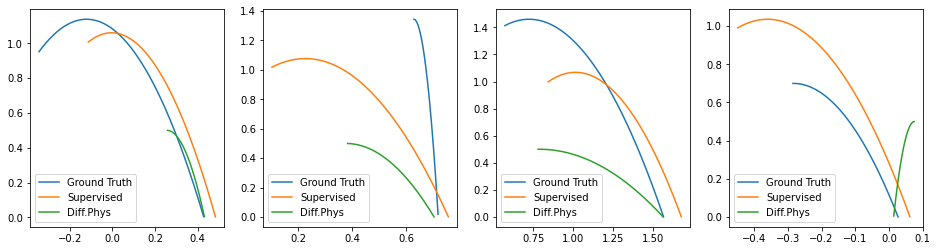

<Figure size 432x288 with 0 Axes>

In [45]:
predictions = math.stack({
    "Ground Truth": x_test.examples[:4],
    "Supervised": math.native_call(net_sup, y_test.examples[:4]),
    "Diff.Phys": math.native_call(net_dp, y_test.examples[:4]),
}, channel('curves'))
vis.plot(sample_trajectory(*predictions.vector), size=(16, 4))

We can see that the differentiable physics network matches the hit point much more precisely than the supervised network, as expected from the loss values.